# Final Project
**Course:** PHYSICS 5300  
**Name:** Suhas Reddy  
**Last name.#**: reddy.434  

---

# Physical Problem:

The problem I am investigating is the **N-body gravitational problem**. This problem involves dynamics, multiple interacting bodies, and sensitivity to initial conditions.

### Description of the System

The physical system consists of N particles interacting through Newtonian gravity in a 2D plane. The gravitational force between two particles $i$ and $j$ is given by:

$$
F_{ij}\ =\  G\ \frac{m_i\ m_j}{(r_i - r_j)^2}
$$

Another important equation that we will be using is Newton’s second law:

$$
F_i\ =\ m_i\ \ddot r_i
$$

Initial positions and velocities will be chosen to represent various different properties of N-body gravitation problems such as chaos, conservation of energy, and stable orbits.

### Lagrangian and Hamiltonian Description

The kinetic energy for a body is given by:

$$
T = \frac{1}{2} m \dot r^2
$$

where m is the mass of the body and r is a generalized coordinate. The gravitational potential energy between 2 bodies is:

$$
U = -\frac{Gm_1m_2}{r_1 - r_2}
$$

where $m_1$ and $m_2$ are the masses of the two bodies, G is the gravitational constant, and $(r_1 - r_2)$ is the distance between the two bodies.

The Lagrangian for this system is given by:

$$
\mathcal{L} = T - V = \sum_{i}^N \frac{1}{2} m_i \dot{r}_i^2 + \sum_{i < j} \frac{G\ m_i\ m_j}{r_i - r_j}
$$

where i < j to account avoid counting the same pair more than once.  

Then you apply Euler-Lagrange equations:

$$
\frac{d}{dt} \left( \frac{\partial \mathcal{L}}{\partial\ {\dot r_i}} \right) - \frac{\partial \mathcal{L}}{\partial {r_i}} = 0
$$

I have used Lagrangian mechanics since I am more comfortable using Lagrangians. However, Hamiltonian mechanics has certain advantages over Lagrangian mechanics which I will be discussing later in this notebook.

### Symmetries and Assumptions

- The system follows conservation of linear momentum and angular momentum.
- The system also follows conservation of energy (though this may not be exact for all integrators).

**Assumptions:**

- All particles are treated as **spherical bodies** with uniform density.
- Gravity is the **only force** considered.
- The simulation is conducted in a **2D plane**.
- If the system has a central body/star, it is going to stay **stationary** at (0, 0). The motion of the other bodies will be calculated relative to this body.

**Note:** I had initially intended to simulate the formation of a solar system from a protoplanetary disk, however I was unable to figure out the logic for collisions. When 2 or more bodies collide, the number of bodies in the system reduces. Although I was able to get the physics down, I was unable to figure out how to create a dynamic variable to change the total number of objects in the system. Since I was unable to figure out collisions, I have done my best to analyze an N-body gravitational system.

If collisions were to be considered, these would be my assumptions:

- The simulation includes **inelastic collisions and mergers**. When two particles come within a defined collision radius (or their positions are sufficiently close), they merge into a single particle with:
    
    - $M = m_1 + m_2$
    - Velocity determined by **conservation of linear momentum**: $$v = \frac {m_1v_1 + m_2v_2}{m_1 + m_2}$$
    - The positions of the bodies are given by their **center of mass**: $$r = \frac{m_1r_1 + m_2r_2}{m_1 + m_2}$$
    - The **radius of the new body**, R, after a collision is given by: $$R = (R_1^3 + R_2^3)^{\frac{1}{3}}$$

In the NBody2D class below, I have left in my logic for collisions and I have also added an option to enable and disable collisions while initializing the system. 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

---

We can create a class called NBody2D which contains everything we need to solve the N-body gravitation problem in 2 dimensions. First, we can find the solution to the Euler-Lagrange equation (for a single body) using the definitions above.

$$
\frac{\partial \mathcal L}{\partial r} = \sum_{i\neq j} \frac{Gm_1m_2}{(r_i - r_j)^2} 
$$

$$
\frac{\partial \mathcal L}{\partial \dot r} = \sum_{i\neq j} m\dot r
$$

$$
\frac{\partial}{\partial t}\frac{\partial \mathcal L}{\partial r} = \sum_{i\neq j} m\ddot r
$$

So we get,

$$
\sum_{i\neq j} |\ m\ddot r\ | = \sum_{i\neq j} \frac{Gm_1m_2}{(r_i - r_j)^2} 
$$

This shows us that the force on a body is equal to the sum of gravtational forces exerted on it by every other body in the system. In order to calculate the trajectories of different bodies in a system, we will need to use vectors. So our solution becomes,

$$
\sum_{i\neq j} m\ddot r = \sum_{i\neq j} \frac{Gm_1m_2}{(r_i - r_j)^2}\ \hat r
\quad\Longrightarrow\quad
\sum_{i\neq j} m\ddot r = \sum_{i\neq j} \frac{Gm_1m_2(r_i - r_j)}{|(r_i - r_j)^3|}
$$

We can now see this final form of the gravitational force exerted on each body to calculate the trajectories of each body in the system.

The NBody2D class also contains three different integrators:

1. **Euler:** This is this simplest integrator. It is a straightforward way of find $y_n$ from $y_{n-1}$, where n is an elements from the t_pts array. For a time-step of $\Delta t$, we get $\mathbf{y}_{n} = \mathbf{y}_{n-1} + \dot y_{n-1} \Delta t$.
   
2. **RK23**(Runge-Kutta23)**:** For this integrator, used scipy's solve_ivp function. This function can itself be specified to use different solution methods (with the method keyword). Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.

3. **Leapfrog:** The leapfrog integrator is the most accurate since it evaluates $\dot r$ at a halfway time step before and after the $r$ evaluation, which is both more accurate and incorporates time reversal: 

$$
\dot r_{i+1/2} = \dot r_{i} + \frac{d{y}_i[1]}{dt}  \Delta t/2    
$$
$$
r_{i+1} = r_i +  \dot r_{i+1/2}  \Delta t  
$$
$$
\dot r_{i+1} = \dot r_{i+1/2} + \frac{d{y}_{i+1}[1]}{dt}  \Delta t/2  
$$

Using this, I have created the NBody2D class which I will be using to initialize different systems. I referenced *Oribital_eqs_with_different_algorithms.ipynb*, a notebook used in class this semester, to understand and learn the implementation of different integrators.

In [2]:
class NBody2D:
    """
    N-body gravitational system in 2D using Lagrangian mechanics.
    """
    def __init__(self, masses, radii, G=1., enable_collisions=False):
        """
        Saves values for the system.
            - masses (array-like): The masses of all of the bodies in the system.
            - radii (array-like): Array of radii of each mass.
            - G (float): Stores value of the gravitational constant.
            - N (int): The number of bodies in the system.
        """
        self.masses = np.array(masses)
        self.radii = np.array(radii)    # for collisions
        self.G = G
        self.N = len(masses)
        self.enable_collisions = enable_collisions

    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx/dt dy/dt d^2x/dt^2 d^2y/dt^2]
        
        Parameters:
            - t (float): time. 
            - y (array-like): A 4N-component array with:
                    y[0] = x1(t), y[1] = x2(t), ...,
                    y[N] = y1(t), y[N+1] = y2(t), ...,
                    y[2N] = dx1/dt, y[2N+1] = dx2/dt, ...,
                    y[3N] = dy1/dt, and y[3N+1] = dy2/dt
        Returns:
            - a list/array?
        """
        # Extract positions and velocities
        pos_x = y[0:self.N]
        pos_y = y[self.N:2*self.N]
        v_x = y[2*self.N:3*self.N]
        v_y = y[3*self.N:4*self.N]

        # Creating arrays to store accelerations
        a_x = np.zeros(self.N)
        a_y = np.zeros(self.N)
        
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    delta_x = pos_x[j] - pos_x[i]
                    delta_y = pos_y[j] - pos_y[i]
                    r_cubed = np.power(delta_x**2 + delta_y**2, 3/2)
                    a_x[i] += self.G * self.masses[j] * delta_x / r_cubed
                    a_y[i] += self.G * self.masses[j] * delta_y / r_cubed

        t_deriv = np.zeros_like(y)    # Creating an array to store velocities and accelerations
        t_deriv[0:self.N] = v_x
        t_deriv[self.N:2*self.N] = v_y
        t_deriv[2*self.N:3*self.N] = a_x
        t_deriv[3*self.N:4*self.N] = a_y
        return t_deriv

    def solve_ode(self, t_pts, y0, method='RK23', abserr=1e-9, relerr=1e-9):
        """
        Uses scipy's solve_ivp to solve an ode using a RK23 integrator.

        Parameters:
            - t_pts (array-like): Array of time steps.
            - y0 (array-like):  Array of initial positions and speeds.
            - method (str): Type of integrator.
            - abserr (float): Absolute error.
            - relerr (float): Relative error.

        Returns:
            - solution: result of solve_ivp
        """
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y0,
                        t_eval=t_pts, method=method, atol=abserr, rtol=relerr)
        return solution

    def euler(self, t_pts, y0):
        """
        Solves an ode using Euler method.

        Parameters:
            - t_pts (array-like): Array of time steps.
            - y0 (array-like): Array of initial conditions.

        Returns:
            - y (array-like): positions and velocities of bodies over time steps.
        """
        delta_t = t_pts[1] - t_pts[0]
        y = np.zeros((len(y0), len(t_pts)))
        y[:, 0] = y0
        for i in range(len(t_pts) - 1):
            t_deriv = self.dy_dt(t_pts[i], y[:, i])
            y[:, i+1] = y[:, i] + delta_t * t_deriv    # Update posititon and velocity at each time step
        return y

    def leapfrog(self, t_pts, y0):    # [Not completely sure if this is right but it works well]
        """
        Solves the ode using a leapfrog integrator. 

        Parameters:
            - t_pts (array-like): Array of time steps.
            - y0 (array-like): Array of initial conditions.

        Returns:
            - y (array-like): positions and velocities of bodies over all time steps.
        """
        delta_t = t_pts[1] - t_pts[0]
        y = np.zeros((len(y0), len(t_pts)))
        y[:, 0] = y0

        pos_x = y0[0:self.N].copy()
        pos_y = y0[self.N:2*self.N].copy()
        v_x = y0[2*self.N:3*self.N].copy()
        v_y = y0[3*self.N:4*self.N].copy()

        a_x, a_y = self.compute_a(pos_x, pos_y)

        for i in range(len(t_pts) - 1):

            # half time-step
            v_x += 0.5 * a_x * delta_t
            v_y += 0.5 * a_y * delta_t

            pos_x += v_x * delta_t
            pos_y += v_y * delta_t

            if self.enable_collisions:    # False by default
                pos_x, pos_y, v_x, v_y = self.collisions(pos_x, pos_y, v_x, v_y)

            a_x, a_y = self.compute_a(pos_x, pos_y)

            # second half time step
            v_x += 0.5 * a_x * delta_t
            v_y += 0.5 * a_y * delta_t

            y[0:self.N, i+1] = pos_x
            y[self.N:2*self.N, i+1] = pos_y
            y[2*self.N:3*self.N, i+1] = v_x
            y[3*self.N:4*self.N, i+1] = v_y

        return y

    def compute_a(self, pos_x, pos_y):
        """
        Calculates the accelerations of each body, to be used in the leapfrog integrator.

        Parameters:
            - pos_x (array-like): x positions of all bodies.
            - pos_y (array-like): y positions of all bodies.

        Returns:
            - a_x (array-like): accelerations of all bodies in the x direction.
            - a_y (array-like): accelerations of all bodies in the y direction.
        """
        a_x = np.zeros(self.N)
        a_y = np.zeros(self.N)
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    delta_x = pos_x[j] - pos_x[i]
                    delta_y = pos_y[j] - pos_y[i]
                    r_cubed = np.power(delta_x**2 + delta_y**2, 3/2)
                    # From the Lagrangian defined above:
                    a_x[i] += self.G * self.masses[j] * delta_x / r_cubed
                    a_y[i] += self.G * self.masses[j] * delta_y / r_cubed
        return a_x, a_y

    # I haven't been able to figure out the logic to change the length of N after a collision.
    def collisions(self, pos_x, pos_y, v_x, v_y):
        """
        Accounts for collisions and calculates the positions and velocities of the new masses.

        Parameters:
            - pos_x (array-like): x positions of all bodies.
            - pos_y (array-like): y positions of all bodies.
            - v_x (array-like): velocities of all bodies in the x direction.
            - v_y (array-like): velocities of all bodies in the y direction.

        Returns:
            - pos_x, 
        """
        i = 0
        while i < self.N:
            j = i + 1
            while j < self.N:
                delta_x = pos_x[i] - pos_x[j]
                delta_y = pos_y[i] - pos_y[j]
                dist = np.sqrt(delta_x**2 + delta_y**2)
                if dist < self.radii[i] + self.radii[j]:    # Check for collision
                    m1, m2 = self.masses[i], self.masses[j]
                    new_mass = m1 + m2
                    new_radius = (self.radii[i]**3 + self.radii[j]**3)**(1/3)

                    pos_x[i] = (m1 * pos_x[i] + m2 * pos_x[j]) / new_mass
                    pos_y[i] = (m1 * pos_y[i] + m2 * pos_y[j]) / new_mass
                    v_x[i] = (m1 * v_x[i] + m2 * v_x[j]) / new_mass
                    v_y[i] = (m1 * v_y[i] + m2 * v_y[j]) / new_mass

                    # Delete object j
                    self.masses = np.delete(self.masses, j)
                    self.radii = np.delete(self.radii, j)
                    pos_x = np.delete(pos_x, j)
                    pos_y = np.delete(pos_y, j)
                    v_x = np.delete(v_x, j)
                    v_y = np.delete(v_y, j)

                    # Update object i
                    self.masses[i] = new_mass
                    self.radii[i] = new_radius
                    self.N -= 1
                else:
                    j += 1
            i += 1
        return pos_x, pos_y, v_x, v_y

    def kinetic(self, y):
        """
        Compute kinetic energy of each body.
        
        Parameters:
            - y (array-like): Contains the positions and velocities of all of the 
            bodies in the system.
        
        Returns:
            - Array of kinetic energies for each body.
        """
        v_x = y[2*self.N:3*self.N]
        v_y = y[3*self.N:4*self.N]
        return 0.5 * self.masses * (v_x**2 + v_y**2)

    def potential(self, y):
        """
        Compute the total potential energy of the system.

        Parameters:
            - y (array-like): Contains the psitions and velocities of all of the
            bodies in the system.

        Returns:
            - U (float): Total potential energy of the system.
        """
        pos_x = y[0:self.N]
        pos_y = y[self.N:2*self.N]
        U = 0.0
        for i in range(self.N):
            for j in range(i):
                dx = pos_x[j] - pos_x[i]
                dy = pos_y[j] - pos_y[i]
                r = np.sqrt(dx**2 + dy**2) 
                U -= self.G * self.masses[i] * self.masses[j] / r
        return U

    def energy(self, y_traj, t_pts):
        """
        Compute total energy over all time steps.
        
        Parameters:
            - y_traj (array-like): Contains the positions and velocities of all of the
            bodies in the system at every time step.
            - t_pts (array-like): Array of time steps.

        Returns:
            - E (array-like): The total energy of the system.
        """
        E = np.zeros(len(t_pts))

        # Energy at each time step
        for i in range(len(t_pts)):
            y_i = y_traj[:, i]
            T = self.kinetic(y_i)     
            U = self.potential(y_i) 
            E[i] = np.sum(T) + U
            
        return E

In [3]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

---
## Conservation of Energy

We can use the NBody2D class to show how well different integrators conserve energy. I have chosen to analyze the **energy conservation for a 2-body system** since the system has a well known analytical solution and there are no rapid/sudden changes in energy as in chaotic systems.

We will analyze and compare the energy conservation between the **Euler**, **RK23**, and **Leapfrog** integrators.

In [4]:
# Masses of the 2 bodies
m1, m2 = 1.0, 1.0
masses = np.array([m1, m2])

# Radii of the bodies
radii = np.zeros(2)

# Gravitational constant (= 1 for simplicity)
G = 1.0

# Initializing the 2 body system
sys = NBody2D(masses, radii, G)

r = 2.0
a = r/2.0
v_rel = np.sqrt(G * (m1 + m2) / r)    # F_grav = F_cent
v = v_rel/2.0

y0 = [+a, -a, 0., 0., 0., 0., +v, -v]

t_pts = np.arange(0., 100., 0.01)

# RK23
sol_RK = sys.solve_ode(t_pts, y0, method='RK23', abserr=1e-9, relerr=1e-9)
t_RK, y_RK = sol_RK.t, sol_RK.y

# Euler
y_Eu = sys.euler(t_pts, y0)

# Leapfrog
y_LF = sys.leapfrog(t_pts, y0)

# Computing total energies
E0 = sys.energy(y_LF, t_pts)[0]    # Initial energy
E_RK = sys.energy(y_RK,  t_RK)
E_Eu = sys.energy(y_Eu,  t_pts)
E_LF = sys.energy(y_LF,  t_pts)

E_RK_rel = (E_RK - E0)/abs(E0)
E_Eu_rel = (E_Eu - E0)/abs(E0)
E_LF_rel = (E_LF - E0)/abs(E0)

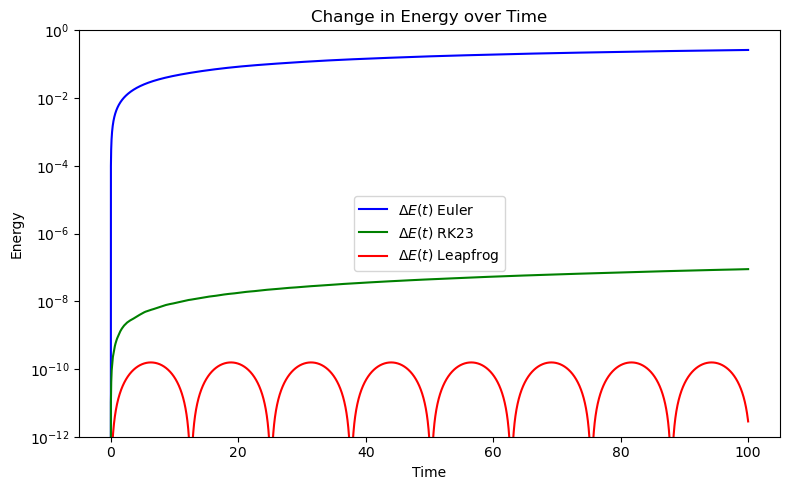

In [5]:
# Create plot to display change in energy over time
plt.figure(figsize=(8,5))
plt.semilogy(t_pts, np.abs(E_Eu_rel), color='blue',  label=r'$\Delta E(t)$ Euler')
plt.semilogy(t_pts, np.abs(E_RK_rel), color='green', label=r'$\Delta E(t)$ RK23')
plt.semilogy(t_pts, np.abs(E_LF_rel), color='red',   label=r'$\Delta E(t)$ Leapfrog')
plt.ylim(1.e-12, 1.)    # (1.e-12, 5)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Change in Energy over Time')
plt.legend()
plt.tight_layout()
plt.show()

It is evident from the plot above that energy conservation varies significantly across different numerical integrators. The blue, green, and red curves correspond to the Euler, RK23, and Leapfrog methods, respectively.

The Euler integrator shows a rapidly increasing energy error that accumulates exponentially over time. This steady drift indicates poor long-term energy conservation. The RK23 integrator also exhibits accumulating energy error, but at a much slower rate than Euler, making it more accurate overall. However, it still does not conserve total energy exactly.

**The Leapfrog integrator maintains conservation of energy the best**. While small errors occur at each step, these errors do not accumulate. Instead, the energy error oscillates periodically around zero, as shown by the red curve. This bounded, non-drifting behavior demonstrates why Leapfrog is particularly well-suited for long-term simulations of conservative systems.

## State Space Diagram

We can compare the different integrators using state space plots as shown below.

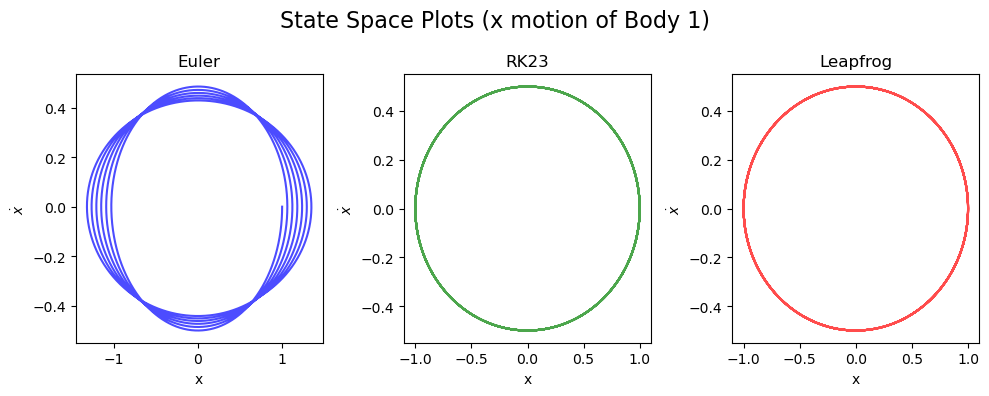

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].plot(y_Eu[0], y_Eu[4], label='Euler', color='blue', alpha=0.7)
axs[1].plot(y_RK[0], y_RK[4], label='RK23', color='green', alpha=0.7)
axs[2].plot(y_LF[0], y_LF[4], label='Leapfrog', color='red', alpha=0.7)

fig.suptitle('State Space Plots (x motion of Body 1)', fontsize=16)
axs[0].set_title('Euler')
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$\dot x$')
axs[1].set_title('RK23')
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$\dot x$')
axs[2].set_title('Leapfrog')
axs[2].set_xlabel('x')
axs[2].set_ylabel(r'$\dot x$')

plt.tight_layout()
plt.show()

The figure above displays the state space plots of the x components of the velocities and positions of body 1 from $t = 0$ to $t = 100$. If we plot the y-components of body 1, or either of the components of body 2, we will get the similar plots.

It is clear that the when using the Euler integrator, the *orbits keep increasing in radius*. The RK23 and Leapfrog integrators appear to have stable orbits. However, *over extremely large periods of time, the RK23 integrator will not produce stable orbits either*. This happens since due to the lack of energy conservation in Euler and RK23 integrators.

---
# Simulations

I created some basicsimulations using [Manim]('https://docs.manim.community/en/stable/tutorials/quickstart.html'). I have listed the different animations along with discussions below.

## **2 Body:**

### **2body_EuLP.py**

I simulated the orbits of 2 bodies by using both the Euler and Leapfrog methods in the same simulation to show the difference in the conservation of energy between the two algorithms. The trajectory calculated by the Leapfrog integrator is displayed in red, while the trajectory calculated by the Euler integrator is in blue. The simulation shows us that the orbits of the two bodies keep expanding for the Euler method while they remai in circular orbits for the Leapfrog method.

The RK23 method would also have expanding orbits in it's longterm motion, however since it's error accuulates much slower than Euler's, the bodies would still look like they remain in the same orbit.

## **3 Body:**

### **3body_stable_EuRKL.py:**

I chose to display the figure-8 configuration stable orbit (Moore, 1993) of the 3 body gravitation problem since I find it pretty cool. Once again I ran the simulation using different integrators. The **Euler method is in blue**, the **RK23 method is green**, and the **Leapfrog method is in Red**.

The Euler trajectory, due to its bad energy conservation, deviates extremely quickly and leads to an unbound orbit. The RK23 method does not deviate significantly in the simulation, however after a few oscillations, the green bodies begin to lead the red bodies in the figure 8 trajectory. I believe that this increased speed because of RK23's sup-par energy conservation will lead to the bodies gradually accelerating and escaping the system.

I used the Leapfrog model as the bench-mark since it conserves energy the best out of the 3 integrators.

I got the initial conditions for this system from [StackExchange](https://astronomy.stackexchange.com/questions/50297/initial-state-for-a-3-body-problem-to-create-figure-8-restricted-to-2d).

### **3body_stable_chaos.py:**

This is my second 3 body simulation, I attempted to display chaos by applying a small perterbation $(10^{-6})$ to the x-component of the initial position one of the bodies. However, you can't really see the change in motion due to this perterbation since it might be too small. So in order to show chaos, I calculated the difference in positions, $\Delta p$, for that body and plotted it against time as shown below.

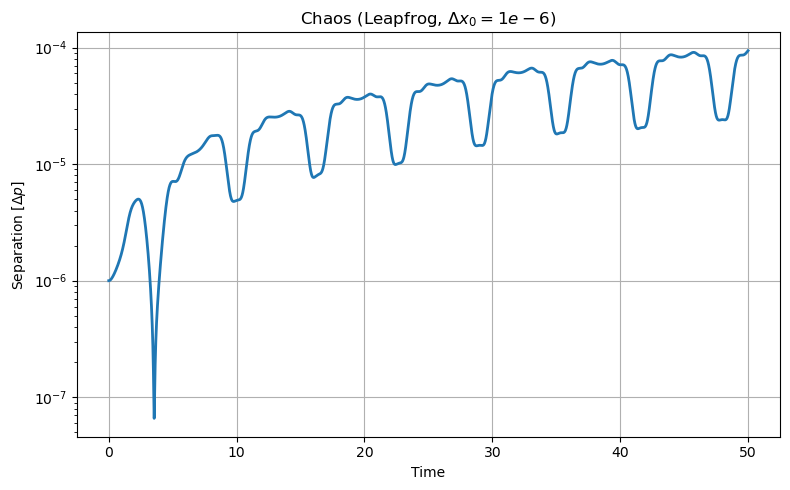

In [7]:
# 1) Initantiate the system
masses = [1.0, 1.0, 1.0]
radii = [0.05, 0.05, 0.05]
system = NBody2D(masses, radii, G=1.0)

# Initial conditions
y0 = np.array([ 0.97000436, -0.97000436,  0.0,
                -0.24308753,  0.24308753,  0.0,
                0.466203685,  0.466203685, -0.93240737,
                0.43236573,   0.43236573,  -0.86473146])
y0p = y0.copy()
y0p[0] += 1e-6  # small perturbation=

dt = 0.01
t_end = 50
t_pts = np.arange(0, t_end + dt, dt)

# Integrate with leapfrog
sol_orig = system.leapfrog(t_pts, y0)
sol_pert = system.leapfrog(t_pts, y0p)

# Compute separation of body 1
delta_x = sol_orig[0, :] - sol_pert[0, :]
delta_y = sol_orig[3, :] - sol_pert[3, :]
delta_p = np.sqrt(delta_x**2 + delta_y**2)

plt.figure(figsize=(8, 5))
plt.semilogy( t_pts, delta_p, linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'Separation [$\Delta p$]')
plt.title(r'Chaos (Leapfrog, $\Delta x_0=1e-6)$')
plt.grid(True)
plt.tight_layout()
plt.show()

The plot above shows that the change in the position body 1 accumulates as time increases. This means that the longterm motion between the two systems will be sigificantly different. This shows that three body gravitiational systems are a great examples of chaotic systems (Lyapunov exponent, $\lambda$ > 1), since their long term motion is extremely sensitive to initial conditions.

## **8 Body:**

### **Solar_System.py:**
I created this simulation to test how well my NBody_2D class works for larger systems. I used a leapfrog integrator for this simulation. The simulation is a bit compact since I tried making it to scale and the path tracers are a bit innacurate since I sped up the actual time by a lot (due to time and storage constraints). However, it looks like the physics of the system is pretty accurate. I got the initial coditions from [NASA's Planetary Fact Sheet](https://nssdc.gsfc.nasa.gov/planetary/factsheet/).

---
# Hamiltonian vs. Lagrangian

I have been used Lagrangians a lot more than I have used Hamiltonians wich is why I chose to use them for this project. Although I used Lagrangian mechanics in this problem, there are many advantages to using Hamiltonian mechanics over Lagragian while solving N-body gravitation problems.

1. The Euler-Lagrange equation gives us a **second order differential equation** which we need to seperate into 2 different first order differential equations. However Hamilton's equations just give us two **first order differential equations** with no extra steps.
2. Most symplectic integrators, which maintain energy conservation, were **designed for first order differential equations**. This makes them better compatible for Hamiltonian mechanics.
3. Hamiltonians also have **better time reversibility** since they work well with symplectic algorithms. ([Wikipedia](https://en.wikipedia.org/wiki/Symplectic_integrator))

Hence, Hamiltonian mechanics results is more convenient to maintain energy conservation in the system, which is crucial for the long term motion of gravitationally bound systems. 

---
# Changes for 3D:

- Since we have another dimension, y would not have a length of 6N.
- I would need to modify my functions to account for the new dimension.
- The physical logic would remain the same but involving x, y, and z instead of just x and y.
- If the system involves motion in the z-direction, the z postion in my animations would no longer be 0.

---

# --------------------------------Thank you!----------------------------------------------
---

### References

- Wikipedia contributors. (n.d.). Symplectic integrator. Wikipedia. Retrieved April 23, 2025, from [https://en.wikipedia.org/wiki/Symplectic_integrator]
- Manim Community Developers. (n.d.). Quickstart tutorial: Using animate syntax to animate methods. Manim Documentation. Retrieved April 23, 2025, from [https://docs.manim.community/en/stable/tutorials/quickstart.html#using-animate-syntax-to-animate-methods]
- The Manim Community Developers. (2025, January 20). Mobject. In Manim – Mathematical Animation Framework (Version 0.19.0) [Documentation]. Retrieved April 24, 2025, from [https://docs.manim.community/en/stable/reference/manim.mobject.mobject.Mobject.html]
- Williams, D. R. (2025, March 18). Planetary fact sheet. NASA National Space Science Data Center. Retrieved April 23, 2025, from [https://nssdc.gsfc.nasa.gov/planetary/factsheet/]
- NumPy Developers. (n.d.). NumPy documentation. NumPy. Retrieved April 23, 2025, from [https://numpy.org/doc/stable/]
- Oliphant, T. E. (2006). A guide to NumPy. CreateSpace Independent Publishing Platform.

I also references Python notebooks that we used in class.